In [1]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 52.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147776 sha256=efd0ce21153a791fb6126858e04e6ca163429f6ff1d59295b550564fbec81b90
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


In [2]:
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import chess
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

move_encoding = {}
p2i = {
    chess.PAWN:   0, chess.KNIGHT: 1, chess.BISHOP: 2,
    chess.ROOK:   3, chess.QUEEN:  4, chess.KING:   5,
}

dataset_path = "/kaggle/input/chess-dataset/lichess_processed_1000000_games_first_15_moves.pkl"
with open(dataset_path, 'rb') as f:
    raw_games = pickle.load(f)
print(f"Loaded {len(raw_games)} games")

raw_games = [g for g in raw_games if g['result'] in ('1-0', '0-1')]
print(f"Games after removing draws: {len(raw_games)}")

eco_codes = sorted({g['eco'] for g in raw_games})
eco_encoding = {eco: idx for idx, eco in enumerate(eco_codes, start=1)}
default_eco = -1

def convert_game_to_tensor(game_data):
    fv = [
        game_data['white_material'], game_data['black_material'],
        game_data['material_balance'],
        int(game_data['white_can_castle']), int(game_data['black_can_castle']),
        game_data['white_center_control'], game_data['black_center_control'],
    ]
    lm = game_data['legal_moves_count'][:15]
    lm += [0] * (15 - len(lm))
    fv.extend(lm)
    fv.append(eco_encoding.get(game_data['eco'], default_eco))
    mi = []
    for mv in game_data['moves'][:15]:
        if mv not in move_encoding:
            move_encoding[mv] = len(move_encoding)
        mi.append(move_encoding[mv])
    mi += [0] * (15 - len(mi))
    fv.extend(mi)
    fv = np.array(fv, dtype=np.float32)

    board_sequence = []
    start_mat = 39
    total_plys = len(game_data['legal_moves_count'])
    for i in range(15):
        prog = (i+1)/15
        w_mat = int(start_mat*(1-prog) + game_data['white_material']*prog)
        b_mat = int(start_mat*(1-prog) + game_data['black_material']*prog)
        mat_bal = w_mat - b_mat
        idx_w, idx_b = i*2, i*2+1
        lm_w = game_data['legal_moves_count'][idx_w] if idx_w < total_plys else 0
        lm_b = game_data['legal_moves_count'][idx_b] if idx_b < total_plys else 0
        board_sequence.append([w_mat, b_mat, mat_bal, lm_w, lm_b, i])
    bs = np.array(board_sequence, dtype=np.float32)

    board = chess.Board()
    board_seq = []
    for mv in game_data['moves'][:15]:
        try:
            board.push_san(mv)
        except:
            board.push_uci(mv)
        one_hot = np.zeros((12,8,8), dtype=np.float32)
        for sq, piece in board.piece_map().items():
            r, f = 7-(sq//8), sq%8
            idx = (0 if piece.color else 6) + p2i[piece.piece_type]
            one_hot[idx, r, f] = 1
        board_seq.append(one_hot)
    while len(board_seq) < 15:
        board_seq.append(np.zeros((12,8,8), dtype=np.float32))
    board_seq = np.stack(board_seq, axis=0)

    return fv, bs, board_seq

class ChessSequenceDataset(Dataset):
    def __init__(self, games, result_map=None):
        self.games = games
        self.result_map = result_map or {'1-0': 0, '0-1': 1}

    def __len__(self):
        return len(self.games)

    def __getitem__(self, idx):
        game = self.games[idx]
        fv, bs, img = convert_game_to_tensor(game)
        label = self.result_map[game['result']]
        return (
            torch.tensor(fv),
            torch.tensor(bs),
            torch.tensor(img),
            torch.tensor(label, dtype=torch.long)
        )

dataset = ChessSequenceDataset(raw_games)
train_size = int(0.8 * len(dataset))
train_ds, test_ds = random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,
                          num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=128,
                          num_workers=4, pin_memory=True)

print("Loaders ready!")


Loaded 976124 games
Games after removing draws: 938864
Loaders ready!


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1 val: 100%|██████████| 1467/1467 [01:30<00:00, 16.14it/s]


Ep1 Train: 0.6483 | Val: 0.6382, Acc: 0.5953
  New best model saved.


Epoch 2 val: 100%|██████████| 1467/1467 [01:31<00:00, 16.09it/s]


Ep2 Train: 0.6357 | Val: 0.6340, Acc: 0.6016
  New best model saved.


Epoch 3 val: 100%|██████████| 1467/1467 [01:31<00:00, 16.11it/s]


Ep3 Train: 0.6336 | Val: 0.6338, Acc: 0.5976
  New best model saved.


Epoch 4 val: 100%|██████████| 1467/1467 [01:30<00:00, 16.12it/s]


Ep4 Train: 0.6326 | Val: 0.6324, Acc: 0.6017
  New best model saved.


Epoch 5 val: 100%|██████████| 1467/1467 [01:31<00:00, 16.03it/s]


Ep5 Train: 0.6321 | Val: 0.6331, Acc: 0.6017


Epoch 6 val: 100%|██████████| 1467/1467 [01:31<00:00, 16.01it/s]


Ep6 Train: 0.6316 | Val: 0.6323, Acc: 0.6023


Epoch 7 val: 100%|██████████| 1467/1467 [01:31<00:00, 15.96it/s]


Ep7 Train: 0.6313 | Val: 0.6318, Acc: 0.6019
  New best model saved.


Epoch 8 val: 100%|██████████| 1467/1467 [01:32<00:00, 15.93it/s]


Ep8 Train: 0.6310 | Val: 0.6326, Acc: 0.6016


Epoch 9 val: 100%|██████████| 1467/1467 [01:32<00:00, 15.93it/s]


Ep9 Train: 0.6308 | Val: 0.6322, Acc: 0.6014


Epoch 10 val: 100%|██████████| 1467/1467 [01:32<00:00, 15.94it/s]


Ep10 Train: 0.6306 | Val: 0.6320, Acc: 0.6013


Epoch 11 val: 100%|██████████| 1467/1467 [01:32<00:00, 15.87it/s]


Ep11 Train: 0.6303 | Val: 0.6318, Acc: 0.6025


Epoch 12 val: 100%|██████████| 1467/1467 [01:31<00:00, 15.95it/s]


Ep12 Train: 0.6295 | Val: 0.6316, Acc: 0.6031
  New best model saved.


Epoch 13 val: 100%|██████████| 1467/1467 [01:32<00:00, 15.89it/s]


Ep13 Train: 0.6292 | Val: 0.6316, Acc: 0.6022


Epoch 14 val: 100%|██████████| 1467/1467 [01:31<00:00, 16.06it/s]


Ep14 Train: 0.6291 | Val: 0.6315, Acc: 0.6032


Epoch 15 val: 100%|██████████| 1467/1467 [01:32<00:00, 15.93it/s]


Ep15 Train: 0.6289 | Val: 0.6318, Acc: 0.6025


Epoch 16 val: 100%|██████████| 1467/1467 [01:31<00:00, 15.95it/s]


Ep16 Train: 0.6288 | Val: 0.6317, Acc: 0.6027


Epoch 17 val: 100%|██████████| 1467/1467 [01:33<00:00, 15.69it/s]


Ep17 Train: 0.6287 | Val: 0.6322, Acc: 0.6000


Epoch 18 val: 100%|██████████| 1467/1467 [01:33<00:00, 15.76it/s]


Ep18 Train: 0.6285 | Val: 0.6318, Acc: 0.6017


Epoch 19 val: 100%|██████████| 1467/1467 [01:32<00:00, 15.83it/s]


Ep19 Train: 0.6279 | Val: 0.6322, Acc: 0.6008


Epoch 20 val: 100%|██████████| 1467/1467 [01:33<00:00, 15.74it/s]


Ep20 Train: 0.6278 | Val: 0.6319, Acc: 0.6008


Epoch 21 val: 100%|██████████| 1467/1467 [01:33<00:00, 15.69it/s]


Ep21 Train: 0.6276 | Val: 0.6317, Acc: 0.6017


Epoch 22 val: 100%|██████████| 1467/1467 [01:33<00:00, 15.67it/s]


Ep22 Train: 0.6275 | Val: 0.6319, Acc: 0.6024
Early stopping triggered.


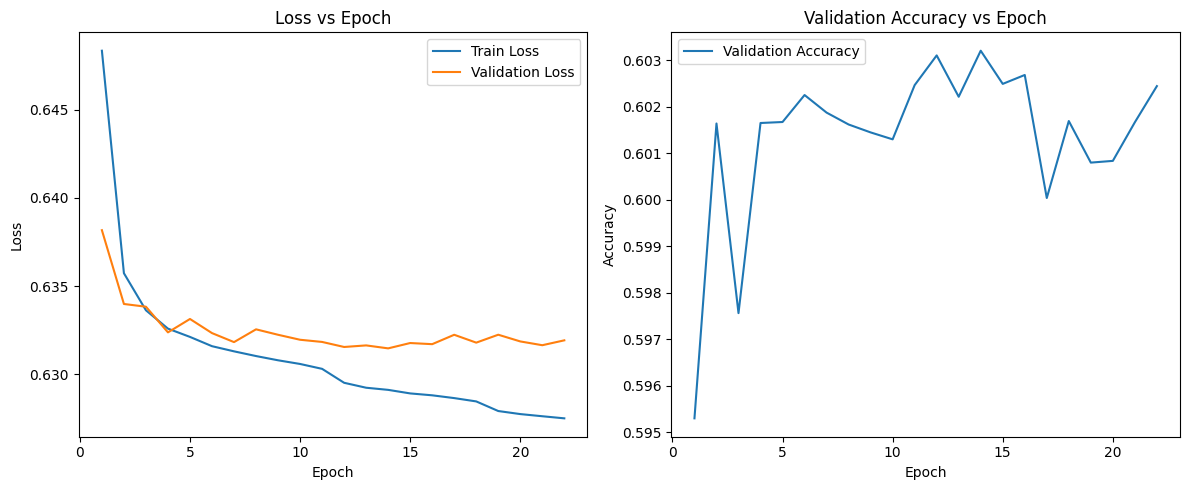

Confusion Matrix:
 [[67640 30056]
 [44594 45483]]

Classification Report:
              precision    recall  f1-score   support

       White       0.60      0.69      0.64     97696
       Black       0.60      0.50      0.55     90077

    accuracy                           0.60    187773
   macro avg       0.60      0.60      0.60    187773
weighted avg       0.60      0.60      0.60    187773



In [3]:
import numpy as np      
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Model class
class ChessModel(nn.Module):
    def __init__(self, tabular_size, seq_num_size, board_ch, H, W,
                 cnn_embed=64, lstm_hidden=64):
        super().__init__()
        self.tab_net = nn.Sequential(
            nn.Linear(tabular_size, 64),
            nn.ReLU()
        )
        self.cnn = nn.Sequential(
            nn.Conv2d(board_ch, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, cnn_embed), nn.ReLU()
        )
        self.lstm = nn.LSTM(
            input_size=cnn_embed + seq_num_size,
            hidden_size=lstm_hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 + 2*lstm_hidden, 64),
            nn.ReLU(),
            nn.Linear(64, 1)   # 🔥 only 1 output now
        )

    def forward(self, tab, num_seq, img_seq):
        B, S, C, H, W = img_seq.shape
        t = self.tab_net(tab)                        
        x = img_seq.view(B*S, C, H, W)
        e = self.cnn(x).view(B, S, -1)             
        seq_in = torch.cat([num_seq, e], dim=2)   
        _, (h_n, _) = self.lstm(seq_in)         
        l = torch.cat([h_n[0], h_n[1]], dim=1)  
        out = torch.cat([t, l], dim=1)             
        return self.classifier(out).squeeze(1)  # 🔥 squeeze output to shape (B,)

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_tab, sample_seq, sample_img, _ = next(iter(train_loader))
_, S, C, H, W = sample_img.shape

model = ChessModel(
    tabular_size=sample_tab.shape[1],
    seq_num_size=sample_seq.shape[2],
    board_ch=C, H=H, W=W
).to(device)

# 🔥 New Loss Function
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Model trainng method
def train_model(model, train_loader, val_loader, epochs=50):
    best_loss = float('inf')
    stop_counter = 0
    patience = 10 
    train_losses = []
    val_losses = []
    val_accuracies = []

    for ep in range(1, epochs+1):
        model.train()
        total_train = 0
        for t, s, i, y in tqdm(train_loader, desc=f"Epoch {ep} train"):
            t, s, i, y = t.to(device), s.to(device), i.to(device), y.to(device).float()
            optimizer.zero_grad()
            out = model(t, s, i)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_train += loss.item() * t.size(0)
        avg_train = total_train / len(train_loader.dataset)

        model.eval()
        total_val = correct = 0
        with torch.no_grad():
            for t, s, i, y in tqdm(val_loader, desc=f"Epoch {ep} val"):
                t, s, i, y = t.to(device), s.to(device), i.to(device), y.to(device).float()
                out = model(t, s, i)
                loss = criterion(out, y)
                total_val += loss.item() * t.size(0)
                preds = (torch.sigmoid(out) > 0.5).long()
                correct += (preds == y.long()).sum().item()
        avg_val = total_val / len(val_loader.dataset)
        acc_val = correct / len(val_loader.dataset)

        print(f"Ep{ep} Train: {avg_train:.4f} | Val: {avg_val:.4f}, Acc: {acc_val:.4f}")
        
        train_losses.append(avg_train)
        val_losses.append(avg_val)
        val_accuracies.append(acc_val)

        scheduler.step(avg_val)

        if avg_val < best_loss - 1e-4:
            best_loss = avg_val
            stop_counter = 0
            torch.save(model.state_dict(), f'best_epoch{ep}.pth')
            print("  New best model saved.")
        else:
            stop_counter += 1
            if stop_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plotting Losses and Accuracy
    epochs_range = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy vs Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# Evaluating Model 
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for t, s, i, y in loader:
            t, s, i = t.to(device), s.to(device), i.to(device)
            out = model(t, s, i)
            preds = (torch.sigmoid(out) > 0.5).long().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds,
          target_names=['White','Black']))

# Training 
model = train_model(model, train_loader, test_loader, epochs=50)
evaluate_model(model, test_loader)
